In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [92]:

# Load the data
train_data = pd.read_csv('data/train_energy.csv')

train_data.head()

,DateTime,EnergyConsumption(kWh)
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9


In [93]:

# Preprocess the data
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
train_data.set_index('DateTime', inplace=True)

train_data.head()

,EnergyConsumption(kWh)
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


In [94]:
scaler = MinMaxScaler()
train_data['EnergyConsumption(kWh)'] = scaler.fit_transform(train_data[['EnergyConsumption(kWh)']])

train_data.head()

,EnergyConsumption(kWh)
DateTime,
2015-11-01 00:00:00,0.086957
2015-11-01 01:00:00,0.069565
2015-11-01 02:00:00,0.043478
2015-11-01 03:00:00,0.017391
2015-11-01 04:00:00,0.034783


In [95]:
# Split the data into train, validation, and test sets
train_size = int(len(train_data) * 0.7)
val_size = int(len(train_data) * 0.2)
test_size = len(train_data) - train_size - val_size

train_set = train_data[:train_size]
val_set = train_data[train_size:train_size + val_size]
test_set = train_data[train_size + val_size:]

print('Train set:', len(train_set))
print('Validation set:', len(val_set))
print('Test set:', len(test_set))

Train set: 7174
Validation set: 2049
Test set: 1026


In [96]:
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour
X_train, y_train = create_sequences(train_set[['EnergyConsumption(kWh)']], SEQ_LENGTH)
X_val, y_val = create_sequences(val_set[['EnergyConsumption(kWh)']], SEQ_LENGTH)
X_test, y_test = create_sequences(test_set[['EnergyConsumption(kWh)']], SEQ_LENGTH)

In [97]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50


/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0134 - val_loss: 0.0060
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 8/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 11/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 12/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - los

In [98]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Test RMSE: {rmse}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Test RMSE: 5.95838346045578


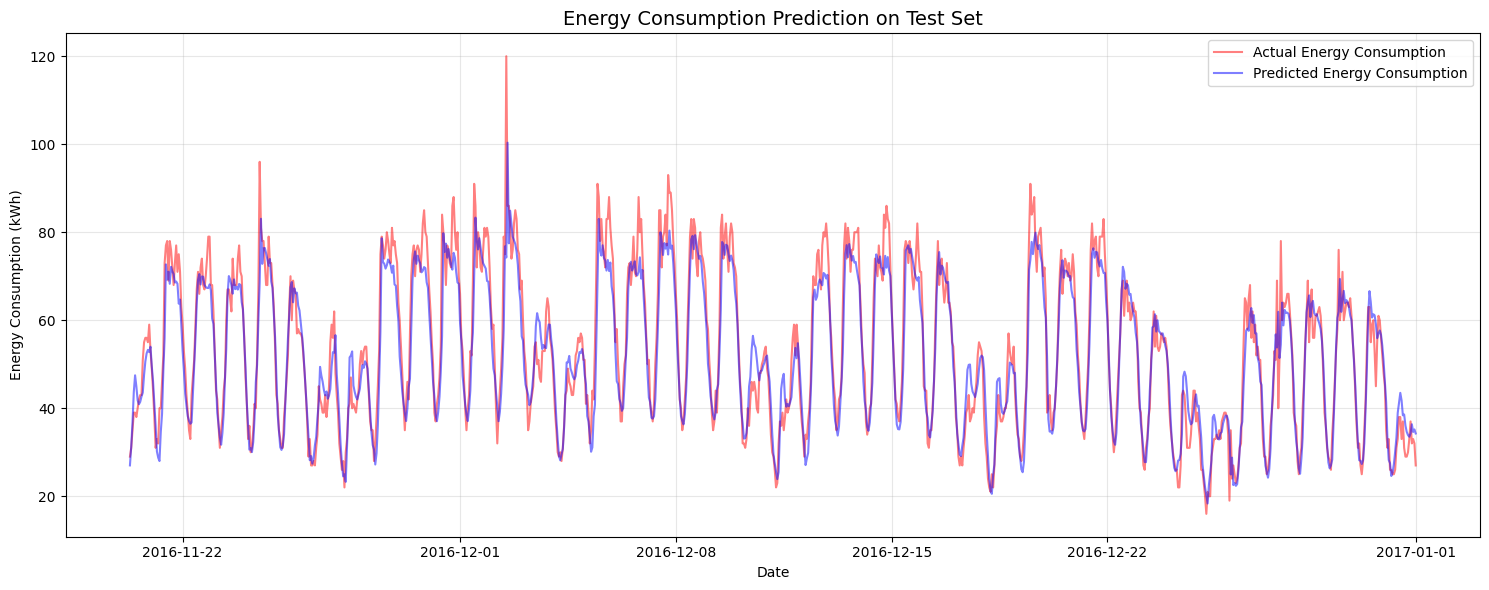

In [99]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(test_set.index[SEQ_LENGTH:], y_test_inv, color='red', alpha=0.5, label='Actual Energy Consumption')

# Plot predicted values
plt.plot(test_set.index[SEQ_LENGTH:], y_pred_inv, color='blue', alpha=0.5, label='Predicted Energy Consumption')

# Customize plot
plt.title('Energy Consumption Prediction on Test Set', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [109]:
# Load the test_energy.csv file
test_data = pd.read_csv('data/test_energy.csv')

# Check if 'DateTime' column exists
if 'DateTime' not in test_data.columns:
    raise KeyError("The 'DateTime' column is missing from the test data.")

# Prepare the test data for prediction
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])
test_data.set_index('DateTime', inplace=True)


In [111]:
# Use the last SEQ_LENGTH data points from train_data to start the prediction
last_sequence = train_data[-SEQ_LENGTH:][['EnergyConsumption(kWh)']].values

predictions = []
current_sequence = last_sequence

for i in range(len(test_data)):
    # Reshape current_sequence to the input shape expected by the model
    current_sequence = current_sequence.reshape((1, SEQ_LENGTH, 1))
    pred = model.predict(current_sequence)  # Make a prediction
    predictions.append(pred[0][0])  # Save the prediction value

    # Reshape pred to match the required shape and append it
    pred_reshaped = np.array(pred[0][0]).reshape((1, 1, 1))  # Reshape to (1, 1, 1)
    current_sequence = np.append(current_sequence[:, 1:, :], pred_reshaped, axis=1)  # Append along time dimension

# Inverse transform the predictions to the original scale
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [112]:
# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'DateTime': test_data.index,
    'EnergyConsumption(kWh)': predictions_inv.flatten()
})

# Save the predictions to a CSV file
predictions_df.to_csv('lstm_submission.csv', index=False)
print("Submission file 'lstm_submission.csv' created successfully!")

Submission file 'lstm_submission.csv' created successfully!


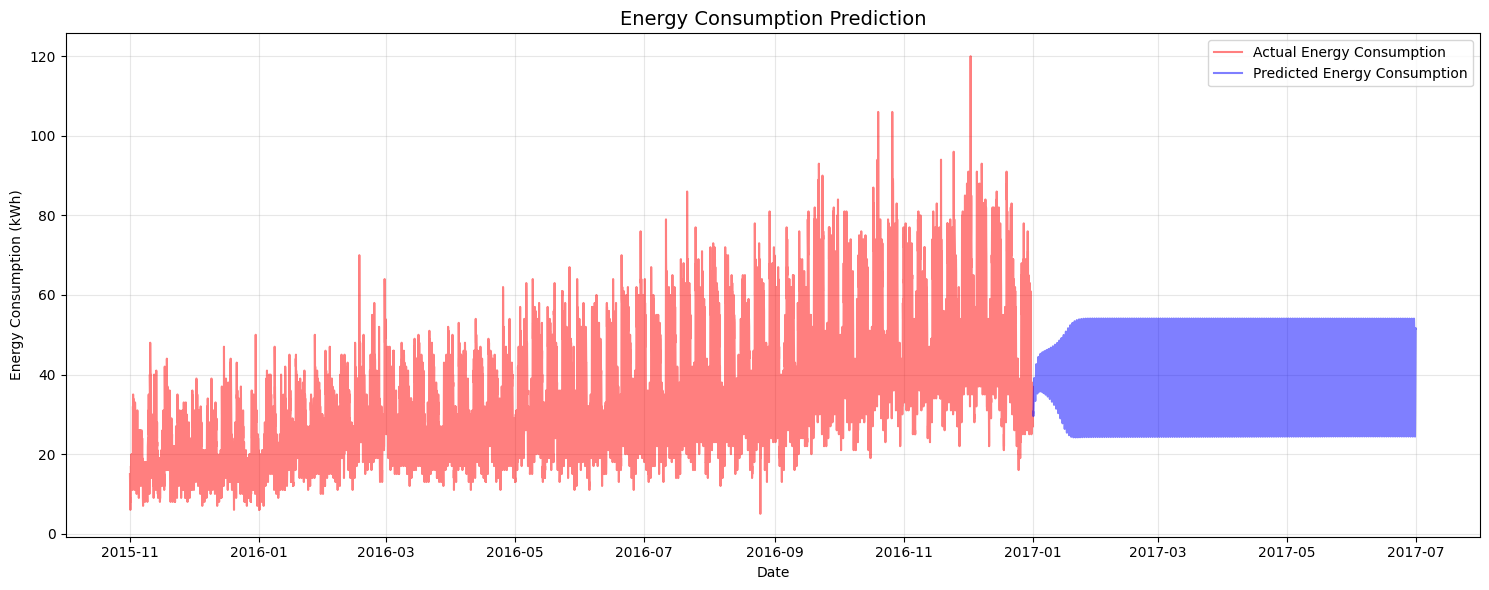

In [113]:

# Plot the combined data
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(train_data.index, scaler.inverse_transform(train_data[['EnergyConsumption(kWh)']]), color='red', alpha=0.5, label='Actual Energy Consumption')

# Plot predicted values
plt.plot(predictions_df['DateTime'], predictions_df['EnergyConsumption(kWh)'], color='blue', alpha=0.5, label='Predicted Energy Consumption')

# Customize plot
plt.title('Energy Consumption Prediction', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()